In [1]:
import sys,os
import numpy as np
import cv2
sys.path.insert(0,'..')
sys.path.insert(0,'../..')
from DataReader.GraphPatchIter import GraphPatchIter
from DataReader.GraphPatchIter2 import GraphPatchIter2
from DataReader.DUCReader import DUCReader
from DataReader.GdalReader import labelViz
from Measure.MeasureEvaluation import MeasureEvaluation
import time
import mxnet as mx
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
def inference(batchsize,data_root,patchsize,step,flist_name,net_prefix,epoch,ctx,rgb_mean,dsize,sample_idx=0,isTrain=True,
              num_class=2,samplerate=8,cell=2):
    reader = DUCReader(flist_name=flist_name, batch_size=batchsize, div=False, data_root=data_root,withGdal=True,
                                            samplerate=samplerate,cell=cell,
                                            rgbMeans=rgb_mean,cutoff_size=patchsize,isTrain=isTrain,DataAug=False,
                                            data_name='data',
                                            label_name='softmax_label')
    reader.isTrain = True
    rsIter=GraphPatchIter2(datareader=reader,patchsize=patchsize,dst_size=dsize,step=step,sample_idx=sample_idx)
    rsIter.bind(ctx,net_prefix,epoch)
    start=time.time()
#     rsIter.reset()
    data_shape=rsIter.data_shape
    print data_shape,rsIter.xl,rsIter.yl
    label_full=rsIter.sample['gt'][0].readImgAsNumpy()
    score_full = np.zeros((num_class,data_shape[0],data_shape[1]), dtype=np.float64)
    for it in rsIter:
        (score,gt,img,coords)=it
        for b in range(0,batchsize):
            reshaped_score = np.zeros((num_class,img.shape[2]/cell,img.shape[3]/cell))
            resized_score = np.zeros((num_class,img.shape[2],img.shape[3]))
            count = 0
            r = samplerate/cell
            for idy in range(r):
                for idx in range(r):
                    reshaped_score[:,idy::r,idx::r] = np.reshape(score[b,:,count*score.shape[2]/(r*r):(count+1)*score.shape[2]/(r*r)],
                                                      (num_class,img.shape[2]/samplerate,img.shape[3]/samplerate))
                    count +=1
            for idx in range(num_class):
                resized_score[idx,...] = cv2.resize(reshaped_score[idx,...],(img.shape[2],img.shape[3]))
            score_full[:,coords[b][0][0]:coords[b][0][1], coords[b][0][2]:coords[b][0][3]] = \
                resized_score[:,coords[b][1][0]:coords[b][1][1], coords[b][1][2]:coords[b][1][3]]
    end=time.time()
    print end-start
    # rsIter=None
    # gc.collect()
    return (label_full,score_full,rsIter)

In [53]:
def run(sample_idx,measure,batchsize=1):
    ctx=mx.gpu(4)
    (label_full, score_full, rsIter) = inference(batchsize=batchsize,data_root='/run/chenkq/data/potsdam',
                        patchsize=448,step=368,flist_name='valset.lst',
                        net_prefix='/mnt/chenkq/models/potsdam/potsdam_resscnn',
                        epoch=300,ctx=ctx,rgb_mean=[[37.257698], [86.55175022, 92.5452277, 85.91596489, 97.63989512],[0]],
                        dsize=448,sample_idx=sample_idx,num_class=6,samplerate=8,cell=2)
    _=measure.calMetricPerClassPerImage(score_full,label_full)
#     _=measure.overlapPixels(0.5,label_full/255,score_full)
    return (label_full, score_full, rsIter)

In [54]:
m = MeasureEvaluation(num_class=6)

# Area 2_11

Bind Done
(6000, 6000) 16 16
58.1273288727
label:  0 , precision: 0.920302 recall: 0.859725 fscore: 0.888983 IoU: 0.800152
label:  1 , precision: 0.927269 recall: 0.969197 fscore: 0.947770 IoU: 0.900724
label:  2 , precision: 0.776597 recall: 0.927169 fscore: 0.845230 IoU: 0.731946
label:  3 , precision: 0.868099 recall: 0.668509 fscore: 0.755341 IoU: 0.606866
label:  4 , precision: 0.910594 recall: 0.846798 fscore: 0.877538 IoU: 0.781797
label:  5 , precision: 0.787221 recall: 0.682262 fscore: 0.730993 IoU: 0.576035
Overall Precision:  0.839977444444
Mean  Accuracy:  0.865013638155
Mean IoU:  0.732920243556


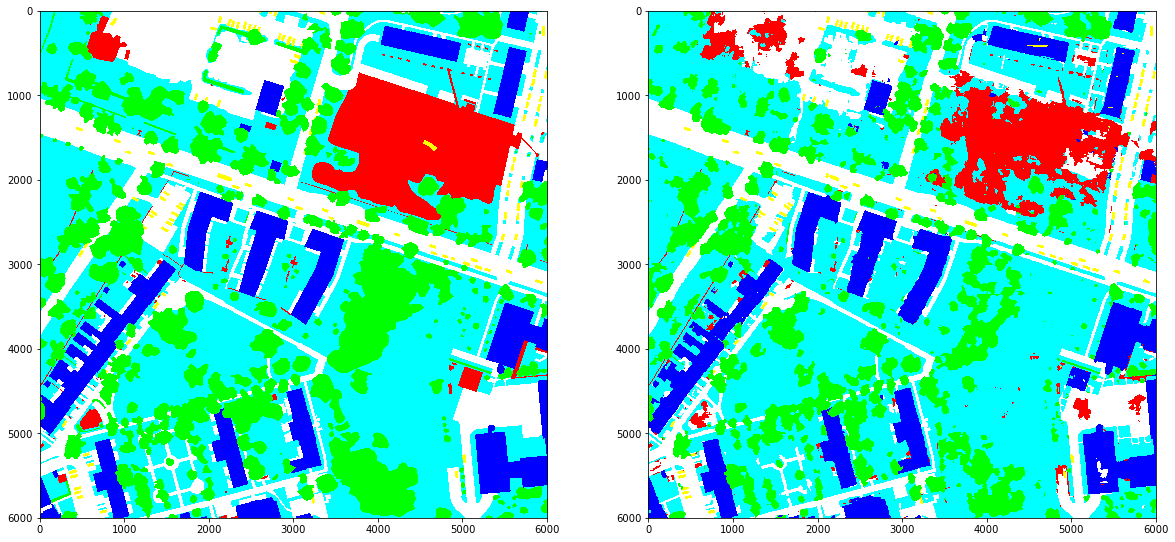

In [55]:
(label_full, score_full, rsIter) = run(0,m)
plt.figure(figsize=(20,20))
converter = labelViz('isprs.txt')
plt.subplot(121)
plt.imshow(converter.Viz(label_full))
plt.subplot(122)
pred = np.argmax(score_full,axis=0)
plt.imshow(converter.Viz(pred))

# Run Area 2_12

Bind Done
(6000, 6000) 16 16
57.3556370735
label:  0 , precision: 0.906307 recall: 0.887625 fscore: 0.896868 IoU: 0.813020
label:  1 , precision: 0.967520 recall: 0.971671 fscore: 0.969591 IoU: 0.940977
label:  2 , precision: 0.865087 recall: 0.949602 fscore: 0.905376 IoU: 0.827112
label:  3 , precision: 0.871523 recall: 0.638495 fscore: 0.737028 IoU: 0.583567
label:  4 , precision: 0.909811 recall: 0.860514 fscore: 0.884476 IoU: 0.792879
label:  5 , precision: 0.272397 recall: 0.422031 fscore: 0.331093 IoU: 0.198389
Overall Precision:  0.878337194444
Mean  Accuracy:  0.798774156044
Mean IoU:  0.692657409172


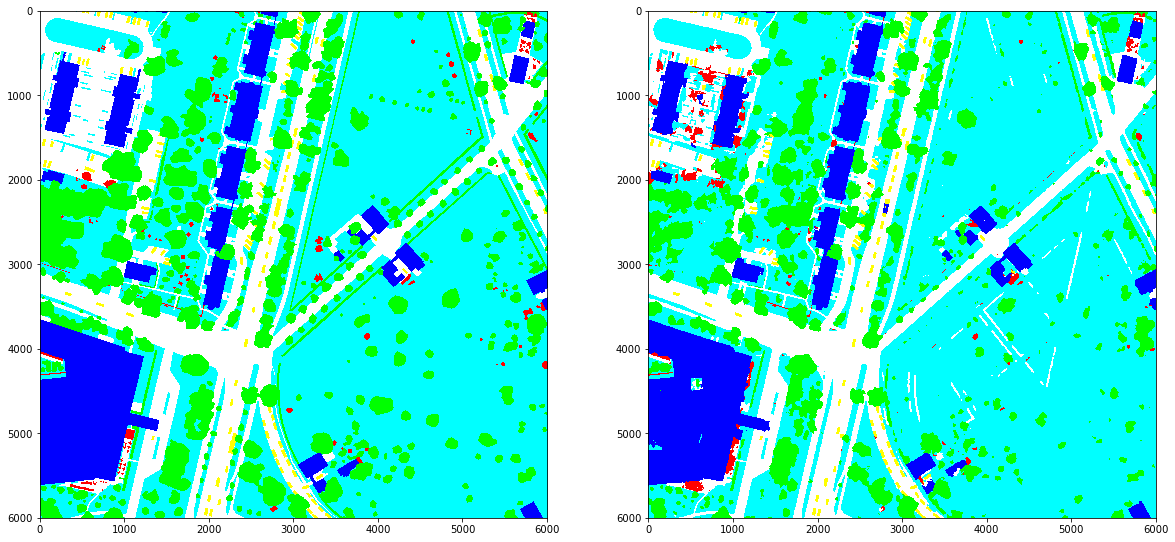

In [56]:
(label_full, score_full, rsIter) = run(1,m)
plt.figure(figsize=(20,20))
converter = labelViz('isprs.txt')
plt.subplot(121)
plt.imshow(converter.Viz(label_full))
plt.subplot(122)
pred = np.argmax(score_full,axis=0)
plt.imshow(converter.Viz(pred))

# Area 4_10

Bind Done
(6000, 6000) 16 16
57.7509300709
label:  0 , precision: 0.867480 recall: 0.837485 fscore: 0.852219 IoU: 0.742492
label:  1 , precision: 0.938117 recall: 0.955131 fscore: 0.946548 IoU: 0.898520
label:  2 , precision: 0.811524 recall: 0.814260 fscore: 0.812890 IoU: 0.684764
label:  3 , precision: 0.739527 recall: 0.866148 fscore: 0.797845 IoU: 0.663679
label:  4 , precision: 0.906508 recall: 0.862313 fscore: 0.883858 IoU: 0.791887
label:  5 , precision: 0.799073 recall: 0.375567 fscore: 0.510974 IoU: 0.343160
Overall Precision:  0.836818638889
Mean  Accuracy:  0.843704796781
Mean IoU:  0.687416929792


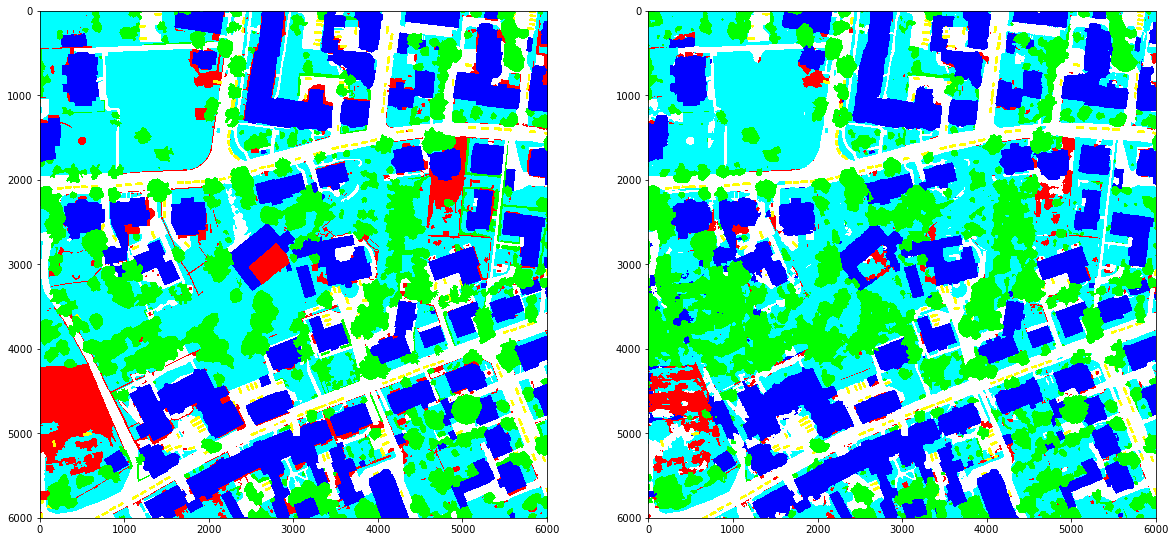

In [57]:
(label_full, score_full, rsIter) = run(2,m)
plt.figure(figsize=(20,20))
converter = labelViz('isprs.txt')
plt.subplot(121)
plt.imshow(converter.Viz(label_full))
plt.subplot(122)
pred = np.argmax(score_full,axis=0)
plt.imshow(converter.Viz(pred))

# Area 5_11

Bind Done
(6000, 6000) 16 16
57.5177788734
label:  0 , precision: 0.885703 recall: 0.928193 fscore: 0.906450 IoU: 0.828906
label:  1 , precision: 0.952322 recall: 0.982545 fscore: 0.967198 IoU: 0.936479
label:  2 , precision: 0.770661 recall: 0.852464 fscore: 0.809501 IoU: 0.679968
label:  3 , precision: 0.921655 recall: 0.752929 fscore: 0.828792 IoU: 0.707639
label:  4 , precision: 0.897179 recall: 0.898170 fscore: 0.897674 IoU: 0.814345
label:  5 , precision: 0.623738 recall: 0.247427 fscore: 0.354307 IoU: 0.215293
Overall Precision:  0.895581416667
Mean  Accuracy:  0.841876271541
Mean IoU:  0.697105178172


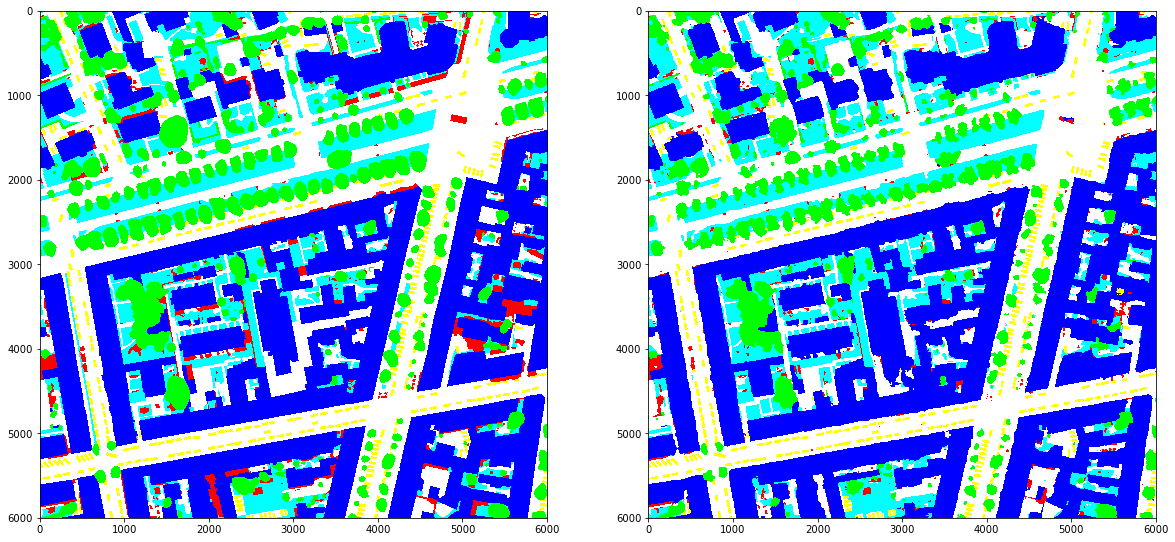

In [58]:
(label_full, score_full, rsIter) = run(3,m)
plt.figure(figsize=(20,20))
converter = labelViz('isprs.txt')
plt.subplot(121)
plt.imshow(converter.Viz(label_full))
plt.subplot(122)
pred = np.argmax(score_full,axis=0)
plt.imshow(converter.Viz(pred))

# Area 6_7

Bind Done
(6000, 6000) 16 16
57.9788649082
label:  0 , precision: 0.687914 recall: 0.847552 fscore: 0.759435 IoU: 0.612168
label:  1 , precision: 0.919675 recall: 0.939952 fscore: 0.929703 IoU: 0.868640
label:  2 , precision: 0.940039 recall: 0.770164 fscore: 0.846664 IoU: 0.734100
label:  3 , precision: 0.663942 recall: 0.879917 fscore: 0.756823 IoU: 0.608781
label:  4 , precision: 0.893798 recall: 0.821002 fscore: 0.855855 IoU: 0.748030
label:  5 , precision: 0.330263 recall: 0.595980 fscore: 0.425007 IoU: 0.269847
Overall Precision:  0.816446472222
Mean  Accuracy:  0.739271736062
Mean IoU:  0.640261046834


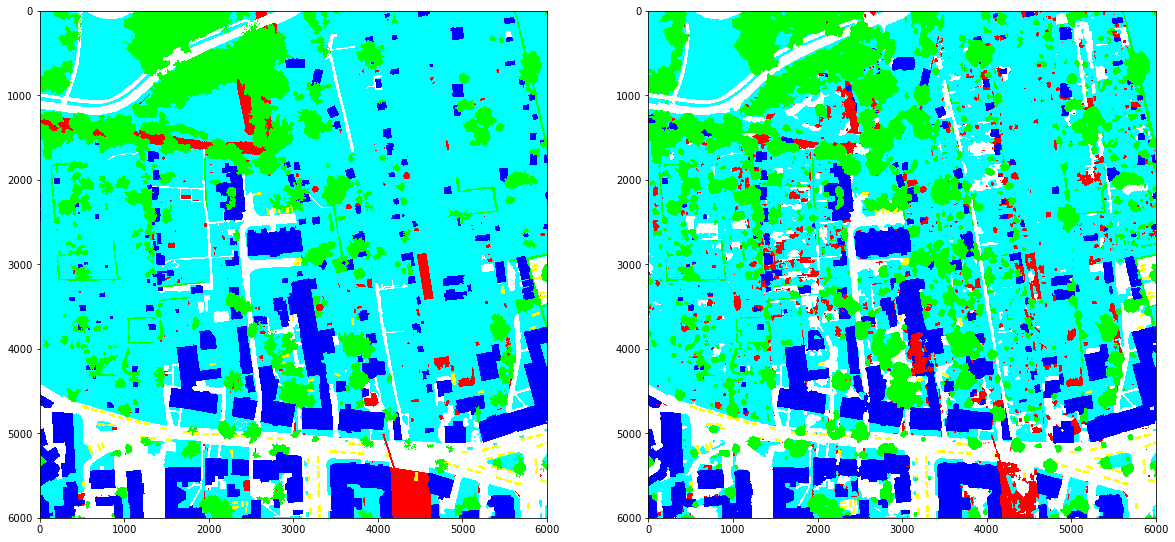

In [59]:
(label_full, score_full, rsIter) = run(4,m)
plt.figure(figsize=(20,20))
converter = labelViz('isprs.txt')
plt.subplot(121)
plt.imshow(converter.Viz(label_full))
plt.subplot(122)
pred = np.argmax(score_full,axis=0)
plt.imshow(converter.Viz(pred))

# Area 7_10

Bind Done
(6000, 6000) 16 16
57.8353669643
label:  0 , precision: 0.868783 recall: 0.954220 fscore: 0.909499 IoU: 0.834019
label:  1 , precision: 0.858002 recall: 0.646702 fscore: 0.737516 IoU: 0.584178
label:  2 , precision: 0.581168 recall: 0.820089 fscore: 0.680260 IoU: 0.515450
label:  3 , precision: 0.826058 recall: 0.774147 fscore: 0.799261 IoU: 0.665641
label:  4 , precision: 0.897352 recall: 0.882543 fscore: 0.889886 IoU: 0.801617
label:  5 , precision: 0.947602 recall: 0.788019 fscore: 0.860474 IoU: 0.755116
Overall Precision:  0.816208638889
Mean  Accuracy:  0.829827470565
Mean IoU:  0.69267006815


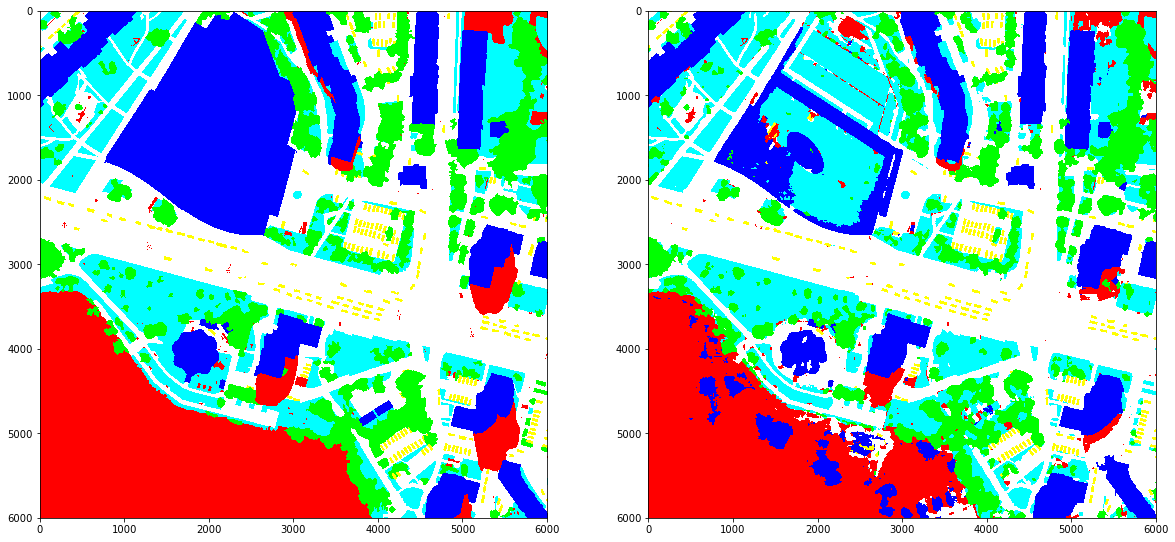

In [60]:
(label_full, score_full, rsIter) = run(5,m)
plt.figure(figsize=(20,20))
converter = labelViz('isprs.txt')
plt.subplot(121)
plt.imshow(converter.Viz(label_full))
plt.subplot(122)
pred = np.argmax(score_full,axis=0)
plt.imshow(converter.Viz(pred))

# Area 7_8

Bind Done
(6000, 6000) 16 16
57.9290459156
label:  0 , precision: 0.843426 recall: 0.865968 fscore: 0.854548 IoU: 0.746036
label:  1 , precision: 0.967342 recall: 0.959359 fscore: 0.963334 IoU: 0.929262
label:  2 , precision: 0.734292 recall: 0.817399 fscore: 0.773620 IoU: 0.630816
label:  3 , precision: 0.866574 recall: 0.773344 fscore: 0.817309 IoU: 0.691059
label:  4 , precision: 0.906490 recall: 0.848345 fscore: 0.876455 IoU: 0.780079
label:  5 , precision: 0.423754 recall: 0.329029 fscore: 0.370432 IoU: 0.227319
Overall Precision:  0.863049083333
Mean  Accuracy:  0.790313105928
Mean IoU:  0.667428502491


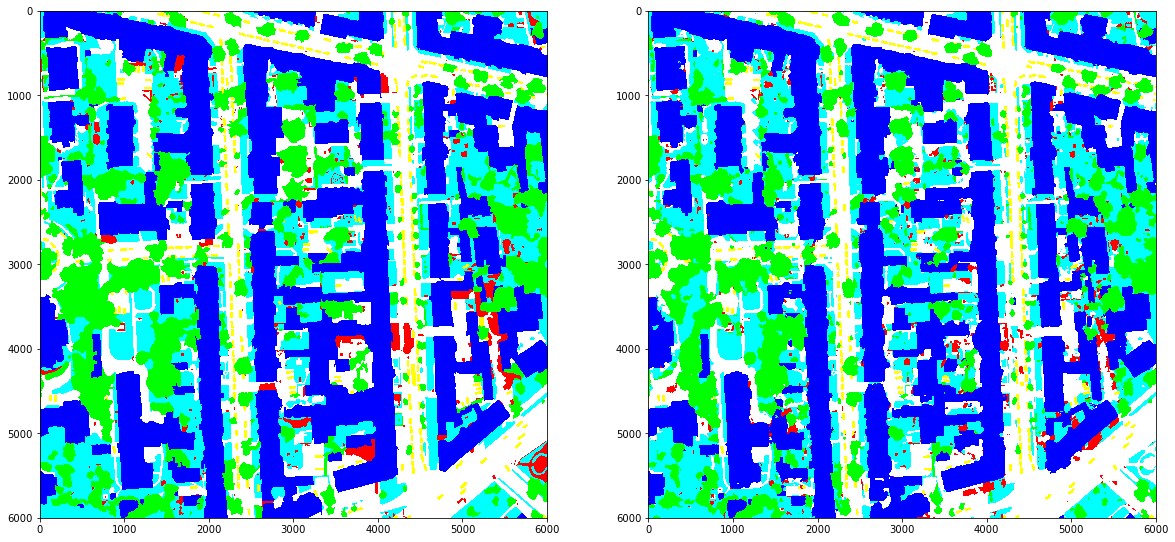

In [61]:
(label_full, score_full, rsIter) = run(6,m)
plt.figure(figsize=(20,20))
converter = labelViz('isprs.txt')
plt.subplot(121)
plt.imshow(converter.Viz(label_full))
plt.subplot(122)
pred = np.argmax(score_full,axis=0)
plt.imshow(converter.Viz(pred))

# calculate metric

In [62]:
m.calMetricOverall()

Overall:
class  0   precision: 0.862501, recall: 0.892629, fscore: 0.877306, IoU: 0.781430
class  1   precision: 0.940137, recall: 0.922077, fscore: 0.931019, IoU: 0.870941
class  2   precision: 0.813284, recall: 0.856413, fscore: 0.834292, IoU: 0.715695
class  3   precision: 0.803601, recall: 0.760843, fscore: 0.781637, IoU: 0.641548
class  4   precision: 0.902204, recall: 0.867707, fscore: 0.884619, IoU: 0.793110
class  5   precision: 0.768250, recall: 0.625354, fscore: 0.689476, IoU: 0.526107
Overall Precision:  0.849488412698
Mean  Accuracy:  0.820837038762
Mean IoU:  0.721471746767


[0.87730628360936935,
 0.93101936422368869,
 0.83429178353782407,
 0.78163747524903648,
 0.88461931230507729,
 0.68947584363233605,
 ('op', 0.84948841269841269),
 ('mean_accuracy', 0.82083703876208403),
 ('miou', 0.72147174676658055)]

## The Influence of patch and step

In [ ]:
#224_224,224_168,448_448,448_368
op_vec = [0.84199423,0,0,0.849491841]
miou_vec = [0.70490314,0,0,0.71553056]

## The influence of compression

In [ ]:
#2048, 64, 128
op = [0.85245188,0.8519]
miou=[0.72886820,0.7285]

In [50]:
help(mx.sym.UpSampling)

Help on function UpSampling in module mxnet.symbol:

UpSampling(*args, **kwargs)
    Perform nearest neighboor/bilinear up sampling to inputs
    This function support variable length of positional input.
    
    Parameters
    ----------
    data : Symbol[]
        Array of tensors to upsample
    scale : int (non-negative), required
        Up sampling scale
    num_filter : int (non-negative), optional, default=0
        Input filter. Only used by bilinear sample_type.
    sample_type : {'bilinear', 'nearest'}, required
        upsampling method
    multi_input_mode : {'concat', 'sum'},optional, default='concat'
        How to handle multiple input. concat means concatenate upsampled images along the channel dimension. sum means add all images together, only available for nearest neighbor upsampling.
    workspace : long (non-negative), optional, default=512
        Tmp workspace for deconvolution (MB)
    
    name : string, optional.
        Name of the resulting symbol.
    
   